<a href="https://colab.research.google.com/github/bedwardsr1-boop/Proyecto-RTF-Tumor/blob/main/Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Url del csv en el repositorio
url = 'https://raw.githubusercontent.com/bedwardsr1-boop/Proyecto-RTF-Tumor/refs/heads/main/Brain%20Tumor.csv'
df = pd.read_csv(url)

df.head()  # Confirmar que se haya cargado correctamente el dataset


,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


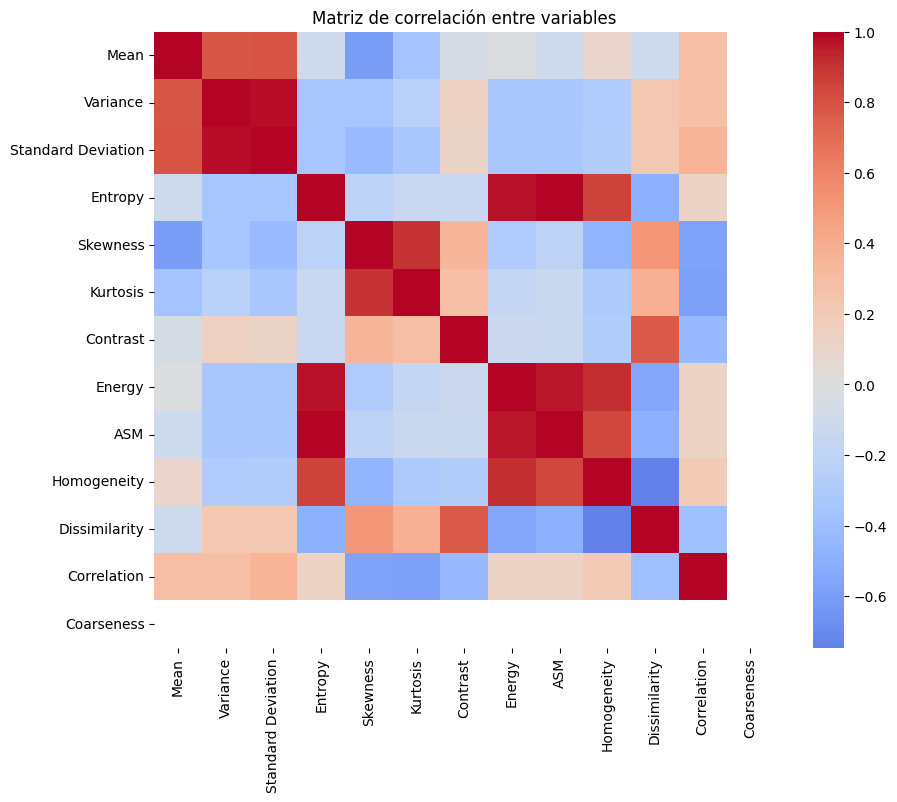


Features altamente correlacionadas (>0.9):
['Standard Deviation', 'Energy', 'ASM', 'Homogeneity']

Importancia de características:
Energy                0.253677
ASM                   0.242993
Entropy               0.212155
Homogeneity           0.141639
Dissimilarity         0.035461
Kurtosis              0.035020
Skewness              0.033436
Variance              0.014178
Standard Deviation    0.010162
Contrast              0.007396
Mean                  0.007325
Correlation           0.006557
Coarseness            0.000000
dtype: float64


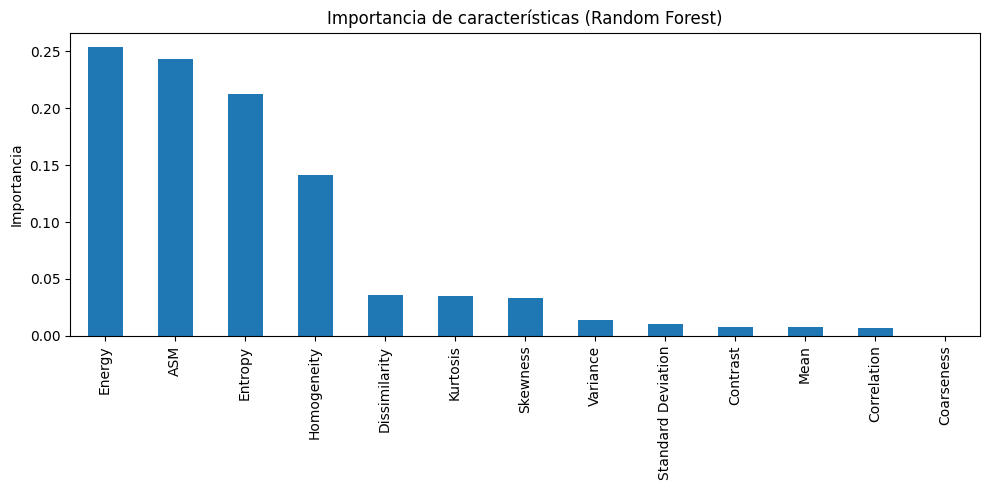


Duplicados: 0
Valores nulos por columna:
 Image                 0
Class                 0
Mean                  0
Variance              0
Standard Deviation    0
Entropy               0
Skewness              0
Kurtosis              0
Contrast              0
Energy                0
ASM                   0
Homogeneity           0
Dissimilarity         0
Correlation           0
Coarseness            0
dtype: int64


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Selección de características para análisis EDA
X_eda = df.drop(columns=["Class", "Image"], errors='ignore')
y_eda = df["Class"]

# Matriz de correlación
plt.figure(figsize=(10,8))
sns.heatmap(X_eda.corr(), cmap='coolwarm', center=0)
plt.title("Matriz de correlación entre variables")
plt.show()

# Detección de alta correlación
corr_matrix = X_eda.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.9)]
print("\nFeatures altamente correlacionadas (>0.9):")
print(high_corr)

# Normalización SOLO para análisis, sin afectar el pipeline final
scaler = StandardScaler()
X_scaled_eda = scaler.fit_transform(X_eda)

# Modelo rápido para observar importancia de características
rf_eda = RandomForestClassifier(n_estimators=200, random_state=42)
rf_eda.fit(X_scaled_eda, y_eda)

# Importancia de características
importances = pd.Series(rf_eda.feature_importances_, index=X_eda.columns).sort_values(ascending=False)
print("\nImportancia de características:")
print(importances)

# Gráfico de importancia
plt.figure(figsize=(10,5))
importances.plot(kind='bar')
plt.title("Importancia de características (Random Forest)")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

# Revisar duplicados y nulos
print("\nDuplicados:", df.duplicated().sum())
print("Valores nulos por columna:\n", df.isnull().sum())

In [3]:
import pandas as pd

# Copia del dataset original para mantener historial
df_clean = df.copy()

# Eliminación de columnas con baja varianza
drop_low_var = ['Coarseness', 'Correlation', 'ASM', 'Entropy']
df_clean = df_clean.drop(columns=drop_low_var, errors='ignore')

# Eliminación de columnas redundantes (altamente correlacionadas)
drop_corr = ['Standard Deviation']  # se retira 1 de las correlacionadas para reducir redundancia
df_clean = df_clean.drop(columns=drop_corr, errors='ignore')

print("Columnas restantes después de la limpieza:")
print(df_clean.columns.tolist())

print("\nTamaño del dataset después de limpieza:", df_clean.shape)


Columnas restantes después de la limpieza:
['Image', 'Class', 'Mean', 'Variance', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'Homogeneity', 'Dissimilarity']

Tamaño del dataset después de limpieza: (3762, 10)


In [4]:
# Tratamiento de Outliers mediante IQR (Ajuste por límites)
df_out = df_clean.copy()

for col in df_out.select_dtypes(include=['float64', 'int64']).columns:
    if col != "Class":  # no tocar la variable objetivo
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_lim = Q1 - 1.5 * IQR
        upper_lim = Q3 + 1.5 * IQR

        df_out[col] = np.where(df_out[col] < lower_lim, lower_lim, df_out[col])
        df_out[col] = np.where(df_out[col] > upper_lim, upper_lim, df_out[col])

df_ready = df_out.copy()  # nuevo dataset “depurado”
print(df_ready.describe())


             Class         Mean     Variance     Skewness     Kurtosis  \
count  3762.000000  3762.000000  3762.000000  3762.000000  3762.000000   
mean      0.447368     9.457813   703.960089     3.874467    17.166297   
std       0.497288     5.625631   445.225533     1.588086    12.816808   
min       0.000000     0.078659     3.145628     1.886014     3.942402   
25%       0.000000     4.982395   363.225459     2.620203     7.252852   
50%       0.000000     8.477531   622.580417     3.422210    12.359088   
75%       1.000000    13.212723   966.954319     4.651737    22.640304   
max       1.000000    25.558214  1872.547609     7.699037    45.721482   

          Contrast       Energy  Homogeneity  Dissimilarity  
count  3762.000000  3762.000000  3762.000000    3762.000000  
mean    121.734175     0.204705     0.479252       4.657668  
std      68.090969     0.129352     0.127929       1.657375  
min       3.194733     0.024731     0.105490       0.681121  
25%      72.125208     

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd

# Separar X y y
X = df_ready.drop(columns=["Class", "Image"], errors='ignore')
y = df_ready["Class"]

# Under-sampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Reconstrucción del dataset balanceado
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced["Class"] = y_resampled.values

print("\nDistribución DESPUÉS del Under-sampling:")
print(Counter(df_balanced["Class"]))
print("\nDistribución ANTES del Under-sampling:")
print(Counter(df["Class"]))



Distribución DESPUÉS del Under-sampling:
Counter({0: 1683, 1: 1683})

Distribución ANTES del Under-sampling:
Counter({0: 2079, 1: 1683})


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Separar variables predictoras y variable objetivo
X = df_balanced.drop(columns=["Class", "Image"], errors='ignore')
y = df_balanced["Class"]

# División del dataset antes de normalizar (evita data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Normalización solo con datos de entrenamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reconstrucción del dataset normalizado para visualización
df_normalized = pd.DataFrame(np.vstack((X_train, X_test)), columns=X.columns)
df_normalized["Class"] = pd.concat([y_train, y_test]).values

df_normalized.head()


,Mean,Variance,Skewness,Kurtosis,Contrast,Energy,Homogeneity,Dissimilarity,Class
0,0.360885,0.619797,-0.152720,-0.205567,-0.386170,-1.184749,-0.820988,0.398809,1
1,-0.305796,1.055610,0.613201,0.563798,-0.498069,-1.260864,-1.635355,0.831006,1
2,1.026614,-0.027734,-1.102728,-0.983221,-0.537119,0.101462,0.459813,-0.755104,0
3,1.385979,0.428359,-1.107680,-0.986905,0.323539,0.181081,0.601615,-0.301796,0
4,0.444439,0.044258,-0.765536,-0.770452,0.393691,0.422148,0.498870,-0.309342,0


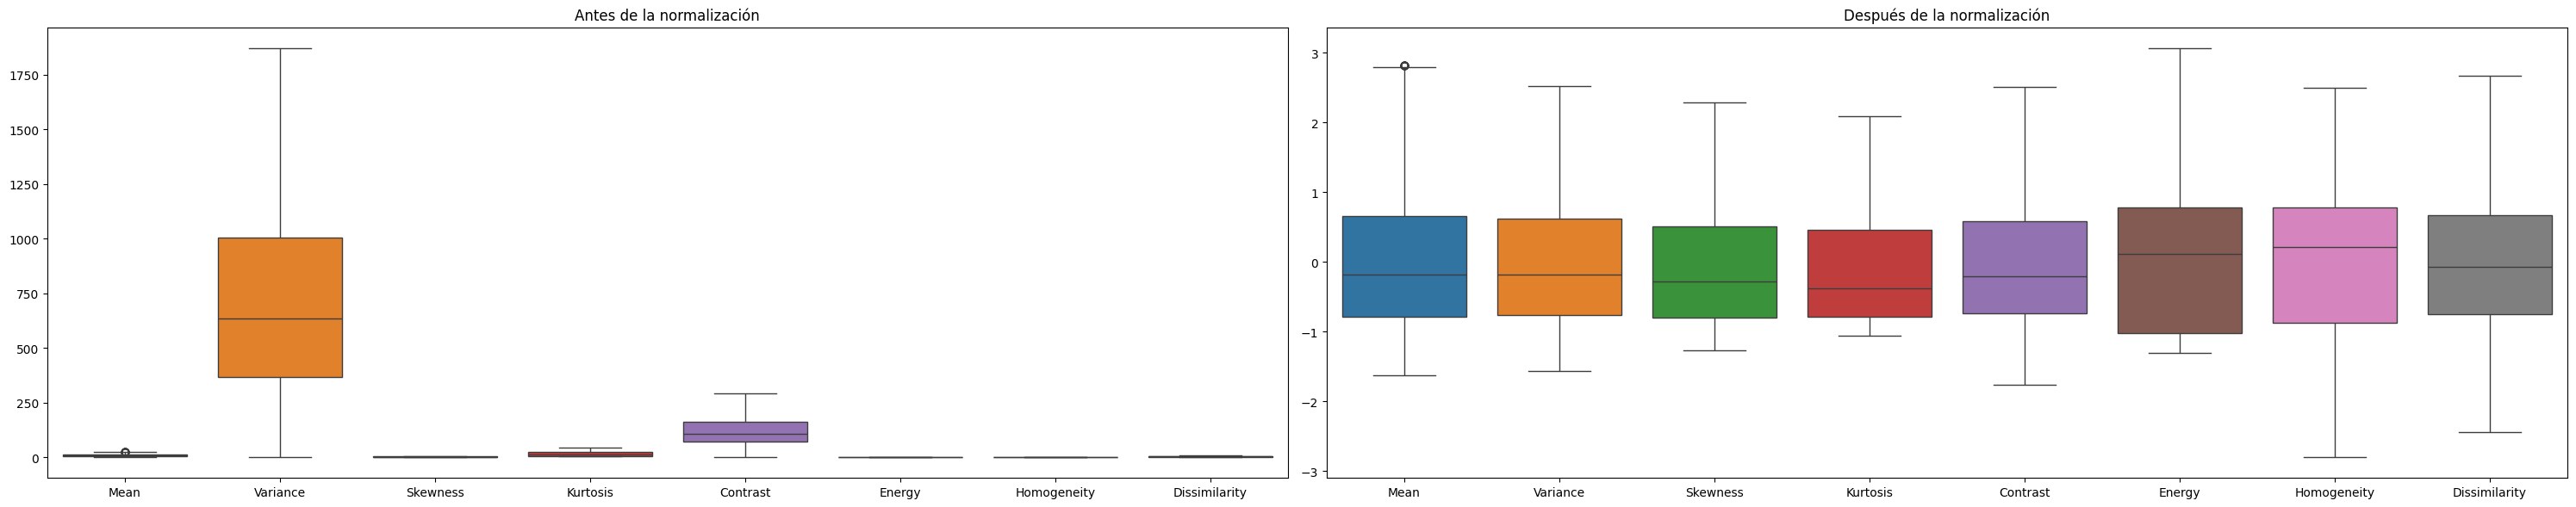

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Comparación de escalas antes vs después
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
sns.boxplot(data=X)
plt.title("Antes de la normalización")

plt.subplot(1,2,2)
sns.boxplot(data=df_normalized.drop(columns=["Class"]))
plt.title("Después de la normalización")

plt.tight_layout()
plt.show()


In [8]:
from sklearn.decomposition import PCA
import numpy as np

# PCA manteniendo el 95% de la varianza
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df_normalized.drop(columns=["Class"]))

# Nuevo dataset reducido
df_pca = pd.DataFrame(X_pca)
df_pca["Class"] = df_normalized["Class"].values

print("Número de componentes principales retenidos:", pca.n_components_)
print(df_pca.head())


Número de componentes principales retenidos: 4
          0         1         2         3  Class
0  0.539677  1.181604 -1.086790 -0.213881      1
1  1.894101  1.028286 -1.351802  0.385040      1
2 -1.875069  0.544762 -0.427988 -0.371707      0
3 -1.662529  1.268634  0.405700 -0.250084      0
4 -1.177946  0.395888  0.570106 -0.355085      0


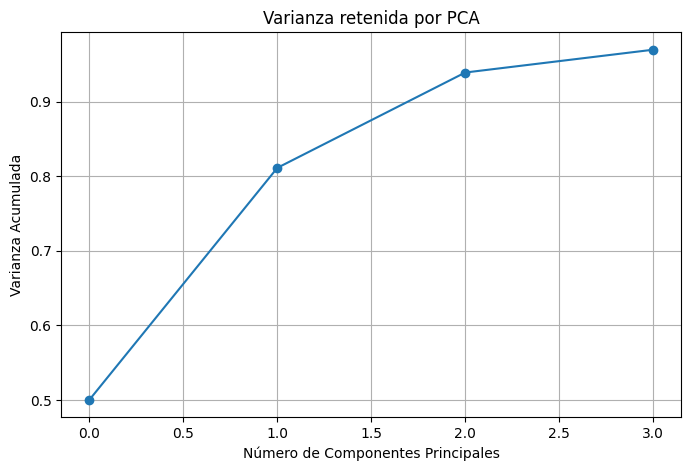

In [9]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Acumulada")
plt.title("Varianza retenida por PCA")
plt.grid()
plt.show()


Tamaño del conjunto de entrenamiento: (2692, 8)
Distribución en entrenamiento: Counter({1: 1346, 0: 1346})


/tmp/ipython-input-1554182208.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="Set2")


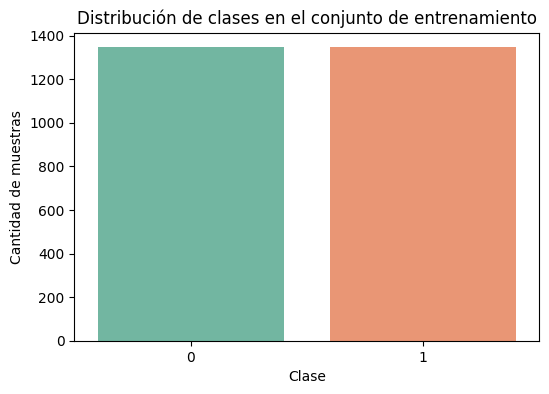

Tamaño del conjunto de prueba: (674, 8)
Distribución en prueba: Counter({0: 337, 1: 337})


/tmp/ipython-input-1554182208.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="Set2")


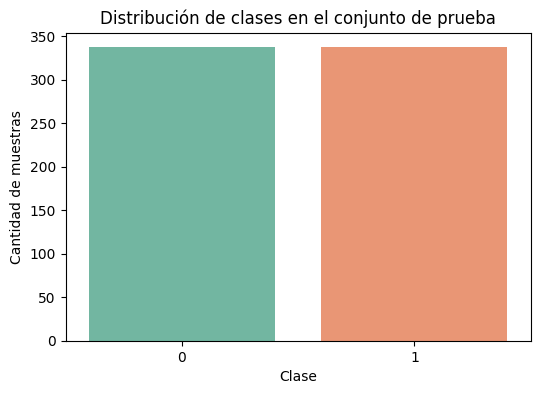

In [10]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Usamos el split ya hecho y normalizado previamente
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Distribución en entrenamiento:", Counter(y_train))

# Gráfico de barras del conjunto de entrenamiento
plt.figure(figsize=(6,4))
sns.countplot(x=y_train, palette="Set2")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Cantidad de muestras")
plt.show()

print("Tamaño del conjunto de prueba:", X_test.shape)
print("Distribución en prueba:", Counter(y_test))

# Gráfico de barras del conjunto de prueba
plt.figure(figsize=(6,4))
sns.countplot(x=y_test, palette="Set2")
plt.title("Distribución de clases en el conjunto de prueba")
plt.xlabel("Clase")
plt.ylabel("Cantidad de muestras")
plt.show()


In [11]:
from sklearn.model_selection import StratifiedKFold

# Configuración de validación cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Validación cruzada configurada con 5 particiones estratificadas.")


Validación cruzada configurada con 5 particiones estratificadas.


In [12]:
from sklearn.ensemble import RandomForestClassifier

# Inicialización del modelo (valores iniciales, serán ajustados más adelante)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

# El modelo queda definido y listo para su posterior entrenamiento y validación
rf_model


RandomForestClassifier(random_state=42)

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
import numpy as np

# Métricas a evaluar en validación cruzada
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# Validación cruzada en el conjunto de entrenamiento
cv_results = cross_validate(
    rf_model,
    X_train, y_train,
    cv=kfold,
    scoring=scoring,
    return_train_score=True
)

print("Resultados de Validación Cruzada (promedio ± desviación estándar):\n")
for metric in scoring:
    mean = cv_results[f"test_{metric}"].mean()
    std = cv_results[f"test_{metric}"].std()
    print(f"{metric:>9}: {mean:.3f} ± {std:.3f}")

# Entrenar modelo final con todo el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

# Predicción rápida en TEST (comprobación preliminar)
y_pred_test = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nAccuracy preliminar en TEST: {test_accuracy:.3f}")

# Señal de posible overfitting
train_acc_mean = cv_results["train_accuracy"].mean()
val_acc_mean = cv_results["test_accuracy"].mean()

print(f"\nAccuracy en TRAIN (CV): {train_acc_mean:.3f}")
print(f"Accuracy en VALID (CV): {val_acc_mean:.3f}")



Resultados de Validación Cruzada (promedio ± desviación estándar):

 accuracy: 0.986 ± 0.003
precision: 0.995 ± 0.006
   recall: 0.976 ± 0.003
       f1: 0.986 ± 0.003
  roc_auc: 0.998 ± 0.001

Accuracy preliminar en TEST: 0.988

Accuracy en TRAIN (CV): 1.000
Accuracy en VALID (CV): 0.986


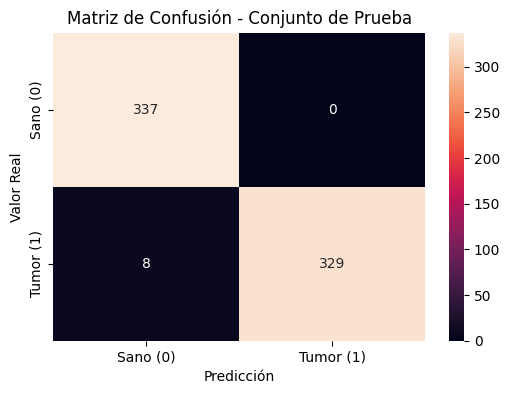


Reporte de clasificación:

              precision    recall  f1-score   support

    Sano (0)       0.98      1.00      0.99       337
   Tumor (1)       1.00      0.98      0.99       337

    accuracy                           0.99       674
   macro avg       0.99      0.99      0.99       674
weighted avg       0.99      0.99      0.99       674



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Sano (0)", "Tumor (1)"],
            yticklabels=["Sano (0)", "Tumor (1)"])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred_test, target_names=["Sano (0)", "Tumor (1)"]))


In [15]:
from sklearn.metrics import accuracy_score

# Predicciones finales en el conjunto de prueba
y_pred_test = rf_model.predict(X_test)

# Accuracy final en test
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy final en TEST: {test_accuracy:.3f}")


Accuracy final en TEST: 0.988


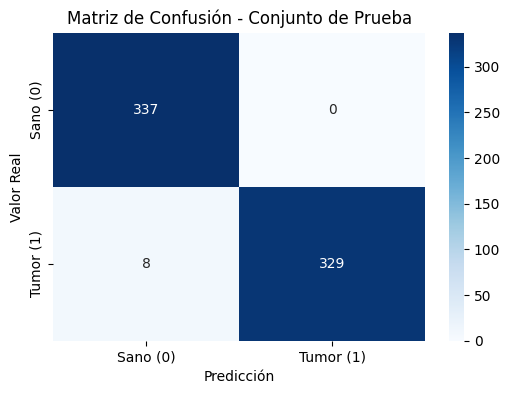

Matriz de confusión:
 [[337   0]
 [  8 329]]


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Sano (0)", "Tumor (1)"],
            yticklabels=["Sano (0)", "Tumor (1)"])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

print("Matriz de confusión:\n", cm)


In [17]:
from sklearn.metrics import classification_report

# Reporte de Clasificación
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred_test, target_names=["Sano (0)", "Tumor (1)"]))



Reporte de clasificación:

              precision    recall  f1-score   support

    Sano (0)       0.98      1.00      0.99       337
   Tumor (1)       1.00      0.98      0.99       337

    accuracy                           0.99       674
   macro avg       0.99      0.99      0.99       674
weighted avg       0.99      0.99      0.99       674



AUC: 0.999


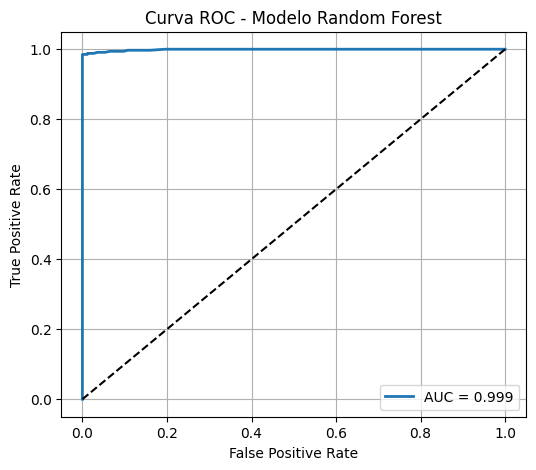

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilidades para clase positiva (tumor = 1)
y_scores = rf_model.predict_proba(X_test)[:,1]

# Cálculo de curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

print(f"AUC: {roc_auc:.3f}")

# Gráfico ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')  # Línea base (modelo aleatorio)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Modelo Random Forest")
plt.legend()
plt.grid()
plt.show()
